In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
import datetime
from copy import deepcopy

In [2]:
# 回测策略
class TestStrategy(bt.Strategy):
    params = (
        ('buy_stocks', None), # 传入各个调仓日的股票列表和相应的权重
    )
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('{}, {}'.format(dt.isoformat(), txt))

    def __init__(self):
         # 读取调仓日期，即每月的最后一个交易日，回测时，会在这一天下单，然后在下一个交易日，以开盘价买入
        self.trade_dates = pd.to_datetime(self.p.buy_stocks['trade_date'].unique(), format='%Y-%m-%d', unit='D')
        self.buy_stock = self.p.buy_stocks # 保留调仓信息
        self.order_list = []  # 记录以往订单，在调仓日要全部取消未成交的订单
        self.buy_stocks_pre = [] # 记录上一期持仓
    
    def next(self):
        # 获取当前的回测时间点
        dt = self.datas[0].datetime.datetime(0)
        # 打印当前时刻的总资产
        self.log('当前总资产 %.2f' %(self.broker.getvalue()))
        # 如果是调仓日，则进行调仓操作
        if dt in self.trade_dates:
            print("--------------{} 为调仓日----------".format(dt))
            #取消之前所下的没成交也未到期的订单
            if len(self.order_list) > 0:
                print("--------------- 撤销未完成的订单 -----------------")
                for od in self.order_list:
                    # 如果订单未完成，则撤销订单
                    self.cancel(od) 
                 #重置订单列表
                self.order_list = [] 
                
            # 提取当前调仓日的持仓列表
            buy_stocks_data = self.buy_stock.query(f"trade_date=='{dt}'")
            long_list = buy_stocks_data['ts_code'].tolist()
            print('long_list', long_list)  # 打印持仓列表
            
            # 对现有持仓中，调仓后不再继续持有的股票进行卖出平仓
            sell_stock = [i for i in self.buy_stocks_pre if i not in long_list]
            print('sell_stock', sell_stock)
            if len(sell_stock) > 0:
                print("-----------对不再持有的股票进行平仓--------------")
                for stock in sell_stock:
                    data = self.getdatabyname(stock)
                    if self.getposition(data).size > 0 :
                        od = self.close(data=data)  
                        self.order_list.append(od) # 记录卖出订单

            # 买入此次调仓的股票：多退少补原则
            print("-----------买入此次调仓期的股票--------------")
            for stock in long_list:
                w = buy_stocks_data.query(f"ts_code=='{stock}'")['weight'].iloc[0] # 提取持仓权重
                data = self.getdatabyname(stock)
                order = self.order_target_percent(data=data, target=w*0.95) # 为减少可用资金不足的情况，留 5% 的现金做备用
                self.order_list.append(order)
                
            self.buy_stocks_pre = long_list  # 保存此次调仓的股票列表
        
    #订单日志    
    def notify_order(self, order):
        # 未被处理的订单
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 已被处理的订单
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, ref:%.0f, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f, Stock: %s' %
                    (order.ref,
                     order.executed.price,
                     order.executed.value,
                     order.executed.comm,
                     order.executed.size,
                     order.data._name))
            else:  # Sell
                self.log('SELL EXECUTED, ref:%.0f, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f, Stock: %s' %
                        (order.ref,
                         order.executed.price,
                         order.executed.value,
                         order.executed.comm,
                         order.executed.size,
                         order.data._name))

In [3]:
daily_price = pd.read_csv("./daily_price.csv", parse_dates=['datetime'])
daily_price = daily_price.set_index(['datetime'])
trade_info = pd.read_csv("./trade_info.csv", parse_dates=['trade_date'])


# 实例化大脑
cerebro_ = bt.Cerebro() 

# 按股票代码，依次循环传入数据
for stock in daily_price['ts_code'].unique():
    # 日期对齐
    data = pd.DataFrame(index=daily_price.index.unique())
    df = daily_price.query(f"ts_code=='{stock}'")[['open','high','low','close','volume','openinterest']]
    data_ = pd.merge(data, df, left_index=True, right_index=True, how='left')
    data_.loc[:,['volume','openinterest']] = data_.loc[:,['volume','openinterest']].ffill()
    data_.loc[:,['open','high','low','close']] = data_.loc[:,['open','high','low','close']].ffill()
    data_.loc[:,['open','high','low','close']] = data_.loc[:,['open','high','low','close']].ffill()
    datafeed = bt.feeds.PandasData(dataname=data_, fromdate=datetime.datetime(2020,11,2), todate=datetime.datetime(2023,9,30))
    cerebro_.adddata(datafeed, name=stock)
    print(f"{stock} Done !") 
    
    


600763.SH Done !
002714.SZ Done !
600606.SH Done !
601155.SH Done !
600025.SH Done !
600875.SH Done !
600989.SH Done !
600886.SH Done !
002230.SZ Done !
600887.SH Done !
000938.SZ Done !
601985.SH Done !
002821.SZ Done !
600010.SH Done !
300408.SZ Done !
600438.SH Done !
002120.SZ Done !
601006.SH Done !
600132.SH Done !
002049.SZ Done !
002602.SZ Done !
300223.SZ Done !
300999.SZ Done !
600009.SH Done !
002252.SZ Done !
002466.SZ Done !
300628.SZ Done !
601901.SH Done !
002352.SZ Done !
601799.SH Done !
000338.SZ Done !
600588.SH Done !
002648.SZ Done !
600028.SH Done !
000596.SZ Done !
603486.SH Done !
300142.SZ Done !
601881.SH Done !
603899.SH Done !
002756.SZ Done !
600115.SH Done !
000063.SZ Done !
002736.SZ Done !
601939.SH Done !
300595.SZ Done !
600048.SH Done !
601216.SH Done !
000157.SZ Done !
688363.SH Done !
601288.SH Done !
600732.SH Done !
600803.SH Done !
300033.SZ Done !
600837.SH Done !
600000.SH Done !
601398.SH Done !
002371.SZ Done !
603501.SH Done !
601698.SH Done

In [4]:
daily_price

,ts_code,open,high,low,close,volume,openinterest
datetime,,,,,,,
2021-02-01,600763.SH,306.10,323.80,306.10,323.80,28659.29,0
2021-02-01,002714.SZ,91.00,97.00,89.44,96.98,535876.14,0
2021-02-01,600606.SH,5.38,5.44,5.34,5.41,270711.99,0
2021-02-01,601155.SH,43.50,45.14,42.61,44.60,206819.27,0
2021-02-01,600025.SH,4.45,4.50,4.41,4.49,290962.60,0
...,...,...,...,...,...,...,...
2023-10-30,601398.SH,4.75,4.76,4.66,4.69,4686115.43,0
2023-10-30,002410.SZ,19.33,19.37,18.25,18.74,514688.45,0
2023-10-30,601169.SH,4.59,4.60,4.51,4.52,703429.60,0


In [5]:
trade_info

,trade_date,ts_code,weight
0,2021-02-01,300628.SZ,0.019710
1,2021-02-01,601788.SH,0.003405
2,2021-02-01,000617.SZ,0.004926
3,2021-02-01,000625.SZ,0.003236
4,2021-02-01,600795.SH,0.001344
...,...,...,...
3191,2023-08-31,300496.SZ,0.003160
3192,2023-08-31,002007.SZ,0.016676
3193,2023-08-31,002180.SZ,0.048743
3194,2023-08-31,688303.SH,0.006796


In [6]:
cerebro = deepcopy(cerebro_)  # 深度复制已经导入数据的 cerebro_，避免重复导入数据 
# 初始资金 100,000,000    
cerebro.broker.setcash(100000000.0) 
# 佣金，双边各 0.0003
cerebro.broker.setcommission(commission=0.0003) 
# 滑点：双边各 0.0001
cerebro.broker.set_slippage_perc(perc=0.0001) 
# 添加策略
cerebro.addstrategy(TestStrategy, buy_stocks=trade_info) # 通过修改参数 buy_stocks ，使用同一策略回测不同的持仓列表

# 添加分析指标
# 返回年初至年末的年度收益率
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='_AnnualReturn')
# 计算最大回撤相关指标
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='_DrawDown')
# 计算年化收益
cerebro.addanalyzer(bt.analyzers.Returns, _name='_Returns', tann=252)
# 计算年化夏普比率
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_SharpeRatio', timeframe=bt.TimeFrame.Days, annualize=True, riskfreerate=0) # 计算夏普比率
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='_SharpeRatio_A')
# 返回收益率时序
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='_TimeReturn')

# 启动回测
result = cerebro.run()


2021-02-01, 当前总资产 100000000.00
--------------2021-02-01 00:00:00 为调仓日----------
long_list ['300628.SZ', '601788.SH', '000617.SZ', '000625.SZ', '600795.SH', '601899.SH', '000895.SZ', '300496.SZ', '601919.SH', '000069.SZ', '601838.SH', '000733.SZ', '002841.SZ', '600926.SH', '000661.SZ', '600570.SH', '600893.SH', '600547.SH', '601901.SH', '601689.SH', '000776.SZ', '002916.SZ', '600438.SH', '300408.SZ', '002594.SZ', '002352.SZ', '000768.SZ', '000938.SZ', '603019.SH', '002459.SZ', '300601.SZ', '601607.SH', '000858.SZ', '002271.SZ', '600332.SH', '600585.SH', '600600.SH', '600030.SH', '600276.SH', '000651.SZ', '601766.SH', '000800.SZ', '600809.SH', '002120.SZ', '601888.SH', '002236.SZ', '600183.SH', '002714.SZ', '600999.SH', '002938.SZ', '601225.SH', '002180.SZ', '601998.SH', '002475.SZ', '600584.SH', '600588.SH', '000001.SZ', '000963.SZ', '000876.SZ', '600606.SH', '600887.SH', '002371.SZ', '300347.SZ', '300454.SZ', '002601.SZ', '601238.SH', '601216.SH', '601800.SH', '000786.SZ', '002460.SZ',

--------------- AnnualReturn -----------------
OrderedDict([(2021, 0.19374336465105024), (2022, -0.1839738653204026), (2023, -0.04118828045486145)])
--------------- DrawDown -----------------
AutoOrderedDict([('len', 453), ('drawdown', 22.402715938535742), ('moneydown', 26965130.319241077), ('max', AutoOrderedDict([('len', 453), ('drawdown', 22.52915127970795), ('moneydown', 27117314.78924106)]))])
--------------- Returns -----------------
OrderedDict([('rtot', -0.06827539570559421), ('ravg', -0.00010552611391900187), ('rnorm', -0.026242111532058642), ('rnorm100', -2.6242111532058643)])
--------------- SharpeRatio -----------------
OrderedDict([('sharperatio', -0.16512585121611678)])
--------------- SharpeRatio_A -----------------
OrderedDict([('sharperatio', -0.1314689410879104)])


<Axes: >

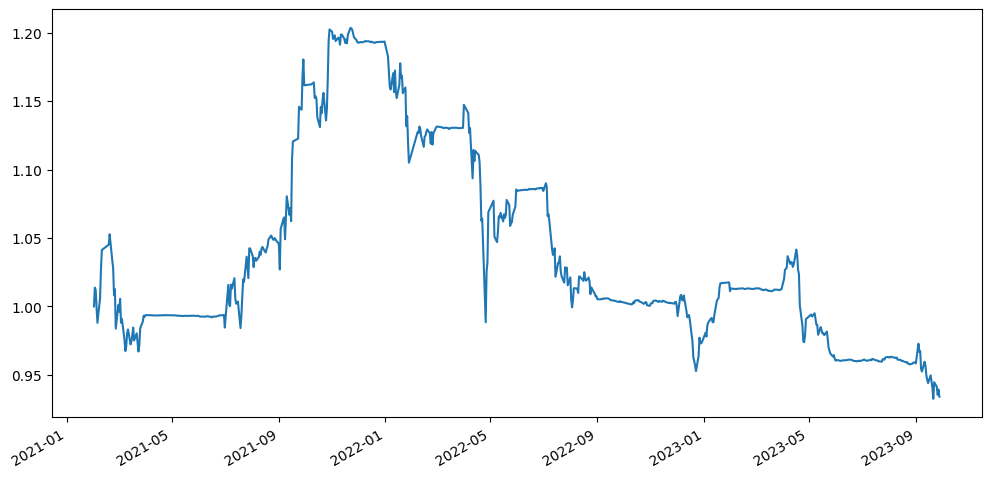

In [7]:
strat = result[0]
print("--------------- AnnualReturn -----------------")
print(strat.analyzers._AnnualReturn.get_analysis())
print("--------------- DrawDown -----------------")
print(strat.analyzers._DrawDown.get_analysis())
print("--------------- Returns -----------------")
print(strat.analyzers._Returns.get_analysis())
print("--------------- SharpeRatio -----------------")
print(strat.analyzers._SharpeRatio.get_analysis())
print("--------------- SharpeRatio_A -----------------")
print(strat.analyzers._SharpeRatio_A.get_analysis())


# 绘制累计收益率
ret = pd.Series(strat.analyzers._TimeReturn.get_analysis())
(ret + 1).cumprod().plot(figsize=(12,6))